# Airport Reliability Dashboard
Filter & Fly has had problems with airports and airlines constantly being delayed or cancelled. This leads to frustrations with their customers who demand a refund for their trip. They have tasked us with creating a dashboard to identify airport and airline risks in order to reduce customer frustration and avoid rebooking/refund costs.

## Key questions include:
* Which airlines have the lowest likelihood of delay, and which airports are consistently most on-time?
* How do delay rates and average delay minutes change by season or month?
* What are the most common causes (carrier, weather, airport) for specific airline–airport combinations?
* Correlation with airlines and airports?
* Ranking reliability on the dashboard (low risk or high risk filters)?
* Risk by state/location and by season?

* Using these insights, the agency can recommend lower-risk routes, suggest better departure seasons, and flag high-risk itineraries that may need extra buffer time or backup options. To clarify, **we are not forecasting** but providing information to help the travel agency make informed business decisions.

In [596]:
from calendar import month

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

## Loading the Data
* year: The calendar year of the recorded flight operations.
* month: The month (1–12) corresponding to the data entry.
* carrier: The airline’s IATA carrier code (e.g., “9E”).
* carrier_name: Full official name of the airline (e.g., “Endeavor Air Inc.”).
* airport: The IATA airport code of the origin airport (e.g., “ABE”).
* airport_name: Full name of the origin airport, including city and state.
* arr_flights: Total number of arrival flights operated in that month for the given airline–airport pair.
* arr_del15: Number of arrival flights delayed by 15 minutes or more (DOT standard definition of a delay).
* carrier_ct: Count of flights delayed due to airline-related issues (e.g., crew delays, maintenance, equipment problems).
* weather_ct: Count of flights delayed because of significant weather conditions.
* nas_ct: Count of flights delayed due to National Airspace System issues (e.g., air traffic control, heavy traffic volume, system capacity).
* security_ct: Count of flights delayed due to security-related factors (e.g., screening issues, security breaches).
* late_aircraft_ct: Count of flights delayed because the aircraft arrived late from a previous flight.
* arr_cancelled: Number of flights that were cancelled in that month for the given airline–airport pair.
* arr_diverted: Number of flights that were diverted to another airport in that month for the given airline–airport pair.
* arr_delay: Total arrival delay minutes across all causes for that airline/airport/month.
* carrier_delay: Total minutes of delay caused by carrier-related issues.
* weather_delay: Total minutes of delay caused by weather.
* nas_delay: Total minutes of delay caused by NAS/air-traffic system constraints.
* security_delay: Total minutes of delay caused by security-related disruptions.
* late_aircraft_delay: Total minutes of delay caused by late-arriving aircraft.

In [597]:
delays_df = pd.read_csv("Airline_Delay_Cause.csv")
delays_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 318017 entries, 0 to 318016
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 318017 non-null  int64  
 1   month                318017 non-null  int64  
 2   carrier              318013 non-null  str    
 3   carrier_name         318013 non-null  str    
 4   airport              318014 non-null  str    
 5   airport_name         318017 non-null  str    
 6   arr_flights          317524 non-null  float64
 7   arr_del15            317285 non-null  float64
 8   carrier_ct           317525 non-null  float64
 9   weather_ct           317523 non-null  float64
 10  nas_ct               317529 non-null  float64
 11  security_ct          317529 non-null  float64
 12  late_aircraft_ct     317529 non-null  float64
 13  arr_cancelled        317529 non-null  float64
 14  arr_diverted         317527 non-null  float64
 15  arr_delay            317523 

# Data Cleaning

I will be dropping most NULL rows within the arr_flights column. This column represents the total number of arrival flights for that particular airport-airline pair, and the NULL values represent 0 flights given that pairing. However for the rows with data in the following columns, I will be keeping those rows and transforming the arr_flights value to 0.

In [598]:
# checking for NULL flight counts
delays_df[delays_df['arr_flights'].isna()].info()

# handling NULL flights, but preserving the flights with valid cancellation, diverted, and delay information
delays_df = delays_df.dropna(
    subset=['arr_flights', 'arr_del15', 'arr_cancelled', 'arr_diverted'],
    how='all'
)
# any preserved flights will still have a 0 flight count
delays_df['arr_flights'] = delays_df['arr_flights'].fillna(0)

<class 'pandas.DataFrame'>
Index: 493 entries, 2872 to 316944
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 493 non-null    int64  
 1   month                493 non-null    int64  
 2   carrier              493 non-null    str    
 3   carrier_name         493 non-null    str    
 4   airport              493 non-null    str    
 5   airport_name         493 non-null    str    
 6   arr_flights          0 non-null      float64
 7   arr_del15            5 non-null      float64
 8   carrier_ct           5 non-null      float64
 9   weather_ct           5 non-null      float64
 10  nas_ct               5 non-null      float64
 11  security_ct          5 non-null      float64
 12  late_aircraft_ct     5 non-null      float64
 13  arr_cancelled        5 non-null      float64
 14  arr_diverted         5 non-null      float64
 15  arr_delay            5 non-null      float64
 16  

I will be converting NULL arr_diverted columns to 0 because this represents the number of flights that were diverted to another airport in that month for the given airline–airport pair, which doesn't impact much else of my dataset.

For the NULL delay columns, the variables add up to the arr_delay, so I handled the NULL values by setting the NULL variable columns (security_delay & carrier_delay) to 0 and then adding the values together to get the arr_delay. Same goes for the count columns and the arr_del15.

In [599]:
# handling NULL diverted flights
delays_df['arr_diverted'] = delays_df['arr_diverted'].fillna(0)

# handling NULL delays
delays_df['security_delay'] = delays_df['security_delay'].fillna(0)
delays_df['carrier_delay'] = delays_df['carrier_delay'].fillna(0)
delay_var = [
    'carrier_delay',
    'weather_delay',
    'nas_delay',
    'security_delay',
    'late_aircraft_delay'
]

# filling in missing delay time with sum of all delay variables
delays_df['arr_delay'] = delays_df['arr_delay'].fillna(delays_df[delay_var].sum(axis=1))

# handling NULL counts
delays_df['carrier_ct'] = delays_df['carrier_ct'].fillna(0)
delays_df['weather_ct'] = delays_df['weather_ct'].fillna(0)
count_var = [
    'carrier_ct',
    'weather_ct',
    'nas_ct',
    'security_ct',
    'late_aircraft_ct',
]

# filling in missing delay counts with sum of all count variables
delays_df['arr_del15'] = delays_df['arr_del15'].fillna(delays_df[count_var].sum(axis=1))

As for the string value columns, the rows with a missing carrier were deemed to me as useless, so I decided to drop them if they had neither a carrier or carrier_name.

The missing airport values were a bit trickier since they had an airport_name, but a missing airport code. So I had to build a map of the groups for the missing values to be correctly filled in with their proper airport codes.

In [600]:
# handling NULL carriers
delays_df = delays_df.dropna(
    subset=['carrier', 'carrier_name'],
    how='all'
)

# handling missing airport cells
missing_airport_codes = delays_df.loc[delays_df['airport'].isna(), 'airport_name']

# creating a map of all unique airports and their airport codes
airport_groups = (
    delays_df
    .dropna(subset=['airport', 'airport_name'])
    .groupby('airport_name')['airport']
    .unique()
)

# filling blank airport cells from the airport groups map
delays_df['airport'] = delays_df['airport'].fillna(
    delays_df['airport_name'].map(airport_groups)
)

# saving cleaned dataframe into new csv file
delays_df.to_csv('delays_transformed.csv', index=False, encoding='utf-8')
delays_df.info()

<class 'pandas.DataFrame'>
Index: 317525 entries, 0 to 318016
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 317525 non-null  int64  
 1   month                317525 non-null  int64  
 2   carrier              317525 non-null  str    
 3   carrier_name         317525 non-null  str    
 4   airport              317525 non-null  object 
 5   airport_name         317525 non-null  str    
 6   arr_flights          317525 non-null  float64
 7   arr_del15            317525 non-null  float64
 8   carrier_ct           317525 non-null  float64
 9   weather_ct           317525 non-null  float64
 10  nas_ct               317525 non-null  float64
 11  security_ct          317525 non-null  float64
 12  late_aircraft_ct     317525 non-null  float64
 13  arr_cancelled        317525 non-null  float64
 14  arr_diverted         317525 non-null  float64
 15  arr_delay            317525 non-n

From this data cleaning, we've lost about 492 rows of data, but given that there were proper cleaning procedures performed on the dataset, it can be considered a necessary loss.

For the sake of easy data analysis, I will be adding 3 new columns that are made up of the airport_name column, including city, state, and the airport_name_cleansed. This essentially makes it easier to parse information rather than pulling from a single, concatenated string. I also rename airport to airport_code and airport_name to airport_full_name for clarity.

In [601]:
# splitting the string by punctuation (identified pattern in the airport_name column)
airport_names = delays_df['airport_name'].str.split(",|:", expand=True)
airport_names.columns = ['city', 'state', 'airport_name_cleansed']

# inserting columns into main dataframe, after airport codes
delays_df.insert(5, "city", airport_names['city'])
delays_df.insert(6, "state", airport_names['state'])
delays_df.insert(8, "airport_name_cleansed", airport_names['airport_name_cleansed'])

# renaming airport to airport_code and airport_name to airport_full_name for clarity
delays_df = delays_df.rename(columns = {"airport": "airport_code", "airport_name": "airport_full_name"})
delays_df["airport_code"] = delays_df["airport_code"].astype(str)

# converting year and month into datetime type
delays_df.insert(0, "year_month", pd.to_datetime(delays_df['year'].astype(str) + '-' + delays_df['month'].astype(str) + '-01'))
delays_df.info()

<class 'pandas.DataFrame'>
Index: 317525 entries, 0 to 318016
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   year_month             317525 non-null  datetime64[us]
 1   year                   317525 non-null  int64         
 2   month                  317525 non-null  int64         
 3   carrier                317525 non-null  str           
 4   carrier_name           317525 non-null  str           
 5   airport_code           317525 non-null  str           
 6   city                   317525 non-null  str           
 7   state                  317525 non-null  str           
 8   airport_full_name      317525 non-null  str           
 9   airport_name_cleansed  317525 non-null  str           
 10  arr_flights            317525 non-null  float64       
 11  arr_del15              317525 non-null  float64       
 12  carrier_ct             317525 non-null  float64       
 13  

# Data Visualizations Figure 1: Number of Cancellations by Carrier
For this visualization, I am looking at the correlation of carrier and their cancellation rates for a specified year. For the simplicity of this line graph, I chose the most cancelled airport within a specified year, which can be changed if needed. Then I made a subset of the main dataframe only containing the airport during the specific year, the months, and the number of cancellations per carrier within each month. This is useful to analyze the reliability of various carriers, within a specific airport and to see the trends as the number of cancellations vary by each month.

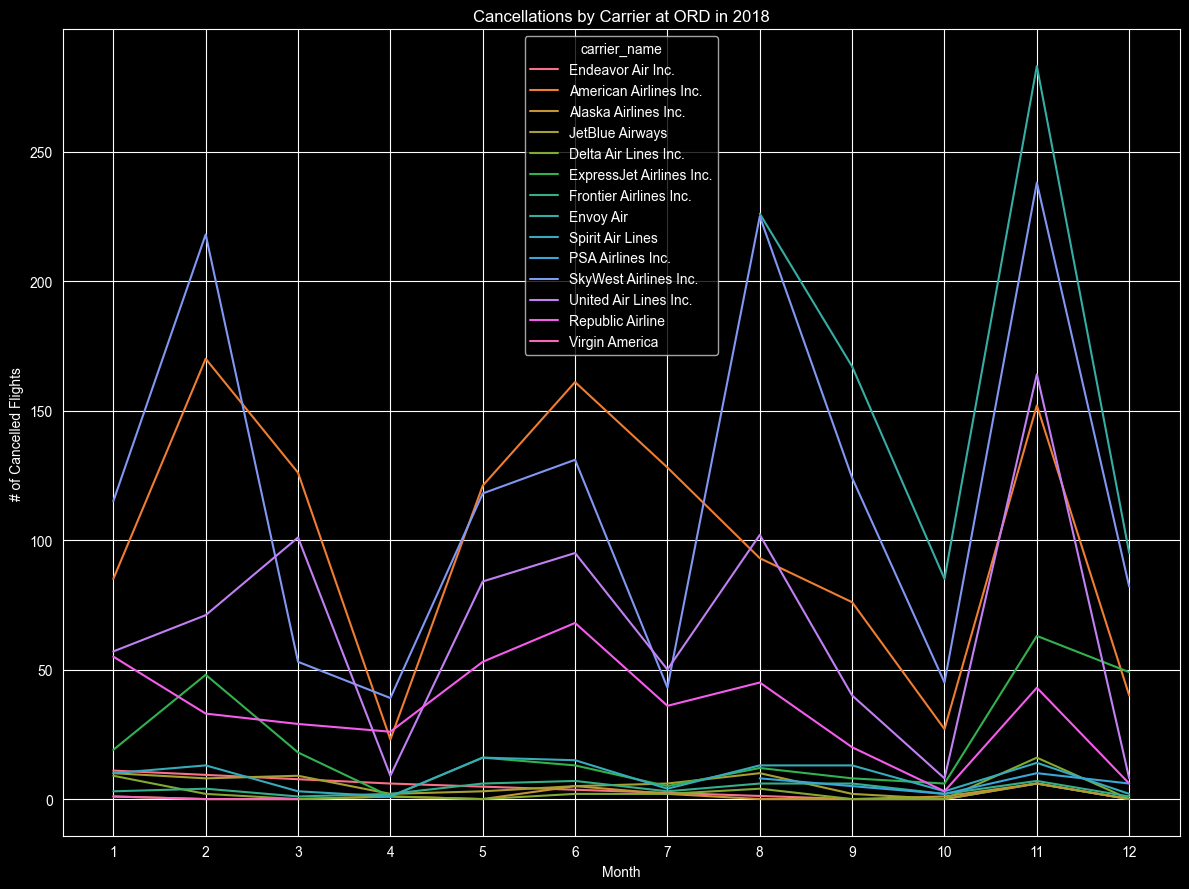

In [608]:
# which airport has the most cancelled flights
year_to_analyze = 2018
most_cancelled_airport = delays_df.loc[delays_df['year'] == year_to_analyze].groupby('airport_code')['arr_cancelled'].sum().idxmax()

# subset of main dataframe
carrier_cancellation_df = delays_df[
    (delays_df["airport_code"] == most_cancelled_airport) &
        (delays_df['year'] == year_to_analyze)
][["month", "arr_cancelled", "carrier_name"]]

plt.figure(figsize=(12,9))
sns.lineplot(
    data=carrier_cancellation_df,
    x='month',
    y='arr_cancelled',
    hue='carrier_name'
)

plt.title(f"Cancellations by Carrier at {most_cancelled_airport} in {year_to_analyze}")
plt.xlabel("Month")
plt.ylabel("# of Cancelled Flights")
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()

# Data Visualizations Figure 2: On-Time Trends by Carrier
For this visualization, I am looking at the relationship between carriers and the number of on-time versus delayed flights for a specified year. For simplicity, I chose the airport with the highest number of flights within that year, which can be changed if needed. I then created a subset of the main dataframe that only includes flights from the selected airport during the specified year and combined the number of on-time flights and different types of delays, sorted by carrier. This is useful for comparing carrier reliability at a single, high-traffic airport and for observing how various delay types contribute to overall flight disruptions across carriers.


             carrier_name  On-Time Flights  Carrier Delay  Weather Delay  \
0    Alaska Airlines Inc.            566.0         2226.0          316.0   
1  American Airlines Inc.           5677.0        41490.0         4539.0   
2    Delta Air Lines Inc.         165155.0       614168.0        61655.0   
3       Endeavor Air Inc.          52522.0       169155.0        25920.0   
4               Envoy Air            631.0          961.0          930.0   

   NAS Delay  Security Delay  Late Aircraft Delay  
0     2260.0             0.0               1738.0  
1    14086.0           419.0              37915.0  
2   195497.0          4059.0             341135.0  
3    54975.0           228.0             114038.0  
4     2106.0            31.0               1509.0  


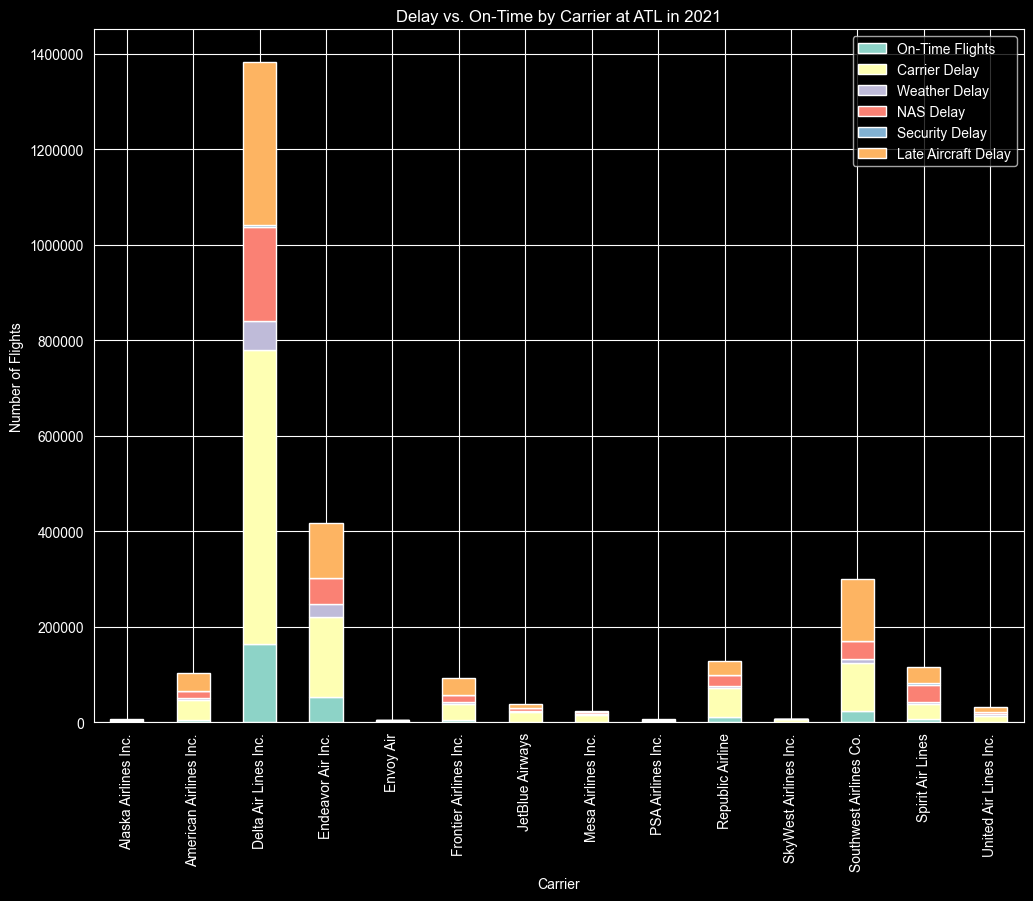

In [603]:
year_to_analyze = 2021
airport_most_flights = delays_df.loc[delays_df['year'] == year_to_analyze].groupby('airport_code')['arr_flights'].sum().idxmax()
no_delays_df = (delays_df[
        (delays_df["airport_code"] == airport_most_flights) &
    (delays_df["year"] == year_to_analyze)
].groupby("carrier_name", as_index=False)[["arr_flights", 'arr_del15', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].sum())

# renaming column names for clarity
no_delays_df = no_delays_df.rename(columns={'carrier_delay': 'Carrier Delay', 'weather_delay': 'Weather Delay', 'nas_delay': 'NAS Delay', 'security_delay': 'Security Delay', 'late_aircraft_delay': 'Late Aircraft Delay'})
no_delays_df.insert(1, 'On-Time Flights', no_delays_df['arr_flights'] - no_delays_df['arr_del15'])
no_delays_df.drop(columns=['arr_flights', 'arr_del15'], inplace=True)
print(no_delays_df.head())

no_delays_df.set_index('carrier_name').plot(kind='bar', stacked=True, figsize=(12,9))
plt.ticklabel_format(style='plain', axis='y')
plt.title(f'Delay vs. On-Time by Carrier at {airport_most_flights} in {year_to_analyze}')
plt.xlabel('Carrier')
plt.ylabel('Number of Flights')
plt.show()

# Data Visualization Figure 3: Weather Delays at an Airport Split by Carrier
For this visualization, I am looking at the distribution of weather-related delays across carriers for a specified month and year. For simplicity, I selected the airport with the highest total number of weather delays within the specified year, which can be changed if needed. I then created a subset of the main dataframe that only includes flights from the selected airport during the specified month and year, along with the associated carriers and their weather delay counts. This visualization is useful for understanding how weather-related delays are distributed among carriers at a high-impact airport and for identifying which carriers contribute most to weather delays during a specific time period.

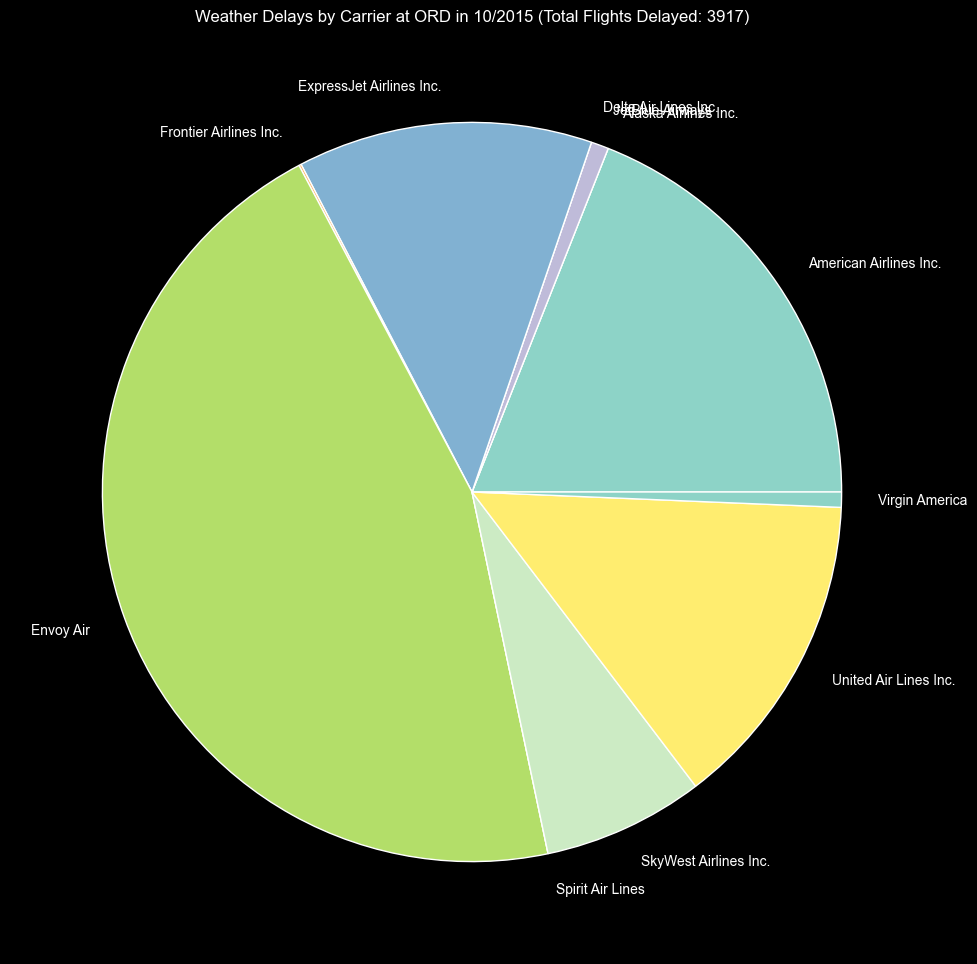

In [607]:
year_to_analyze = 2015
month_to_analyze = 10
airport_most_weather_delays = delays_df.loc[delays_df['year'] == year_to_analyze].groupby('airport_code')['weather_delay'].sum().idxmax()

weather_delays_df = delays_df[
    (delays_df["airport_code"] == airport_most_weather_delays) &
    (delays_df["year"] == year_to_analyze) &
    (delays_df["month"] == month_to_analyze)
][["weather_delay", "carrier_name"]]

total_weather_delays = weather_delays_df['weather_delay'].sum().astype(int)

plt.figure(figsize=(12, 12))
plt.pie(weather_delays_df['weather_delay'], labels=weather_delays_df['carrier_name'])
plt.title(f'Weather Delays by Carrier at {airport_most_weather_delays} in {month_to_analyze}/{year_to_analyze} (Total Flights Delayed: {total_weather_delays})', loc='center')
plt.show()

# Data Visualization Figure 4: Delay for Specific Carrier
For this visualization, I am looking at how different types of delays for a specific carrier change across the months of a year at a selected airport. I created a subset of the data for Delta, at SeaTac, and in 2017 as an example, summing the delays by type for each month. This helps show seasonal patterns and which delays are most common at different times of the year.

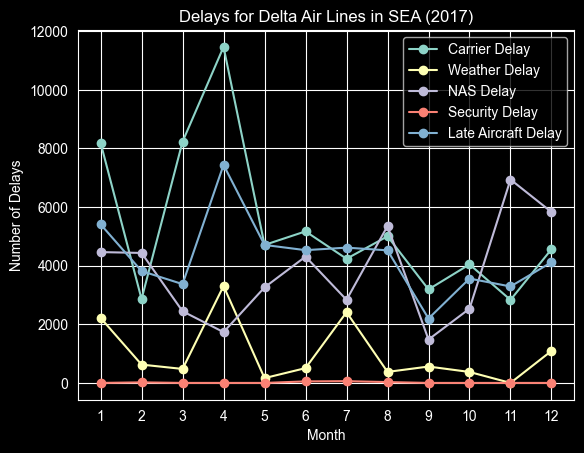

In [605]:
year_to_analyze = 2017
carrier_to_analyze = 'Delta Air Lines'
airport_to_analyze = 'SEA'

monthly_delays_df = delays_df[
    (delays_df['year'] == year_to_analyze) &
    (delays_df['carrier_name'].str.contains(carrier_to_analyze)) &
    (delays_df['airport_code'] == airport_to_analyze)
].groupby('month')[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].sum().reset_index()
monthly_delays_df = monthly_delays_df.rename(columns={'carrier_delay': 'Carrier Delay', 'weather_delay': 'Weather Delay', 'nas_delay': 'NAS Delay', 'security_delay': 'Security Delay', 'late_aircraft_delay': 'Late Aircraft Delay'})

monthly_delays_df.plot(
    x='month',
    kind='line',
    marker='o'
)
plt.title(f'Delays for {carrier_to_analyze} in {airport_to_analyze} ({year_to_analyze})')
plt.xlabel('Month')
plt.ylabel('Number of Delays')
plt.xticks(range(1,13))
plt.show()

# The Findings
### Next Steps:
From the EDA, the team should focus on which carriers and airports have the most delays, the types of delays, and how they change over months. The next step is turning these insights into clear metrics and visualizations for stakeholders. Turning the quantified metrics into descriptive qualities to describe each carrier would help our stakeholder make informative decisions, which would be ideal.
### Dataset:
I think the dataset is sufficient enough to answer the stakeholder questions, but finding flight origins or months with unusual happenings, like government shutdowns or massive historical events, could be interesting to dive into if we wanted to explore more about the reasoning behind airline delays/cancellations.
### Data Mining & Patterns:
I saw that in weather delays visualization, even when changing the month, there is a carrier who makes the majority of these delays. While we don't necessarily know if these delays are caused by weather in the destination or the origin location, it might be worth diving into.

Also, in the general breakdown of various delay causes in visualization figure 2, there's a large amount of flights with Delta, but it might be worth breaking these statistics down into percentages and seeing if there's a pattern of the various delay types.

In November 2018 of Figure 1, there is a cancellation hike in the visualization that might be worth exploring. While not all of the carriers experience this rise in cancellations, it's a good amount of data to show a correlation.
### Story & Dashboard:
The story is about flight reliability, which carriers and airports perform well, which delays matter most, and when.
Some dashboard ideas that would be definitely beneficial to communicating information would be stacked/grouped bars for delay types by carrier, line charts for monthly trends, pie charts for delay distribution, correlations in delays for airports and carriers. It would also be worth adding KPIs like on-time %, total delays, and average delays per carrier.
### Knowns & Unknowns:
There were some rows with data but missing carrier names and I'm wondering if these were independent carriers or something else. I do know that I dropped rows with 0 flights between airlines and airports to clean the data, so I also wonder if the reasons behind these lack of flights is due to a partnership being broken off or otherwise.
### Reflection:
Doing this EDA gave me a good understanding of the dataset and trends. I feel more confident knowing which metrics to track and how to work with the team on the dashboard. I think being immersed in the data is an easy way of understanding the data on a deep level and will assist in being able to explain and assist my teammates with this project effectively.